In [29]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [30]:
G = nx.les_miserables_graph()
communities = list(nx.community.girvan_newman(G))

In [31]:
modularity_data = []

for k in range(len(communities)-2):
    community_modularity = nx.community.modularity(G, communities[k])
    modularity_data.append((k+1, community_modularity))
    
modularity_df = pd.DataFrame(modularity_data, columns=['k', 'modularity'])
modularity_df


,k,modularity
0,1,0.073866
1,2,0.269230
2,3,0.270759
3,4,0.350301
4,5,0.385300
...,...,...
69,70,0.002032
70,71,0.000104
71,72,-0.016850
72,73,-0.026922


<Axes: title={'center': 'Modularity Trend for Girvan-Newman Community Detection'}, xlabel='k'>

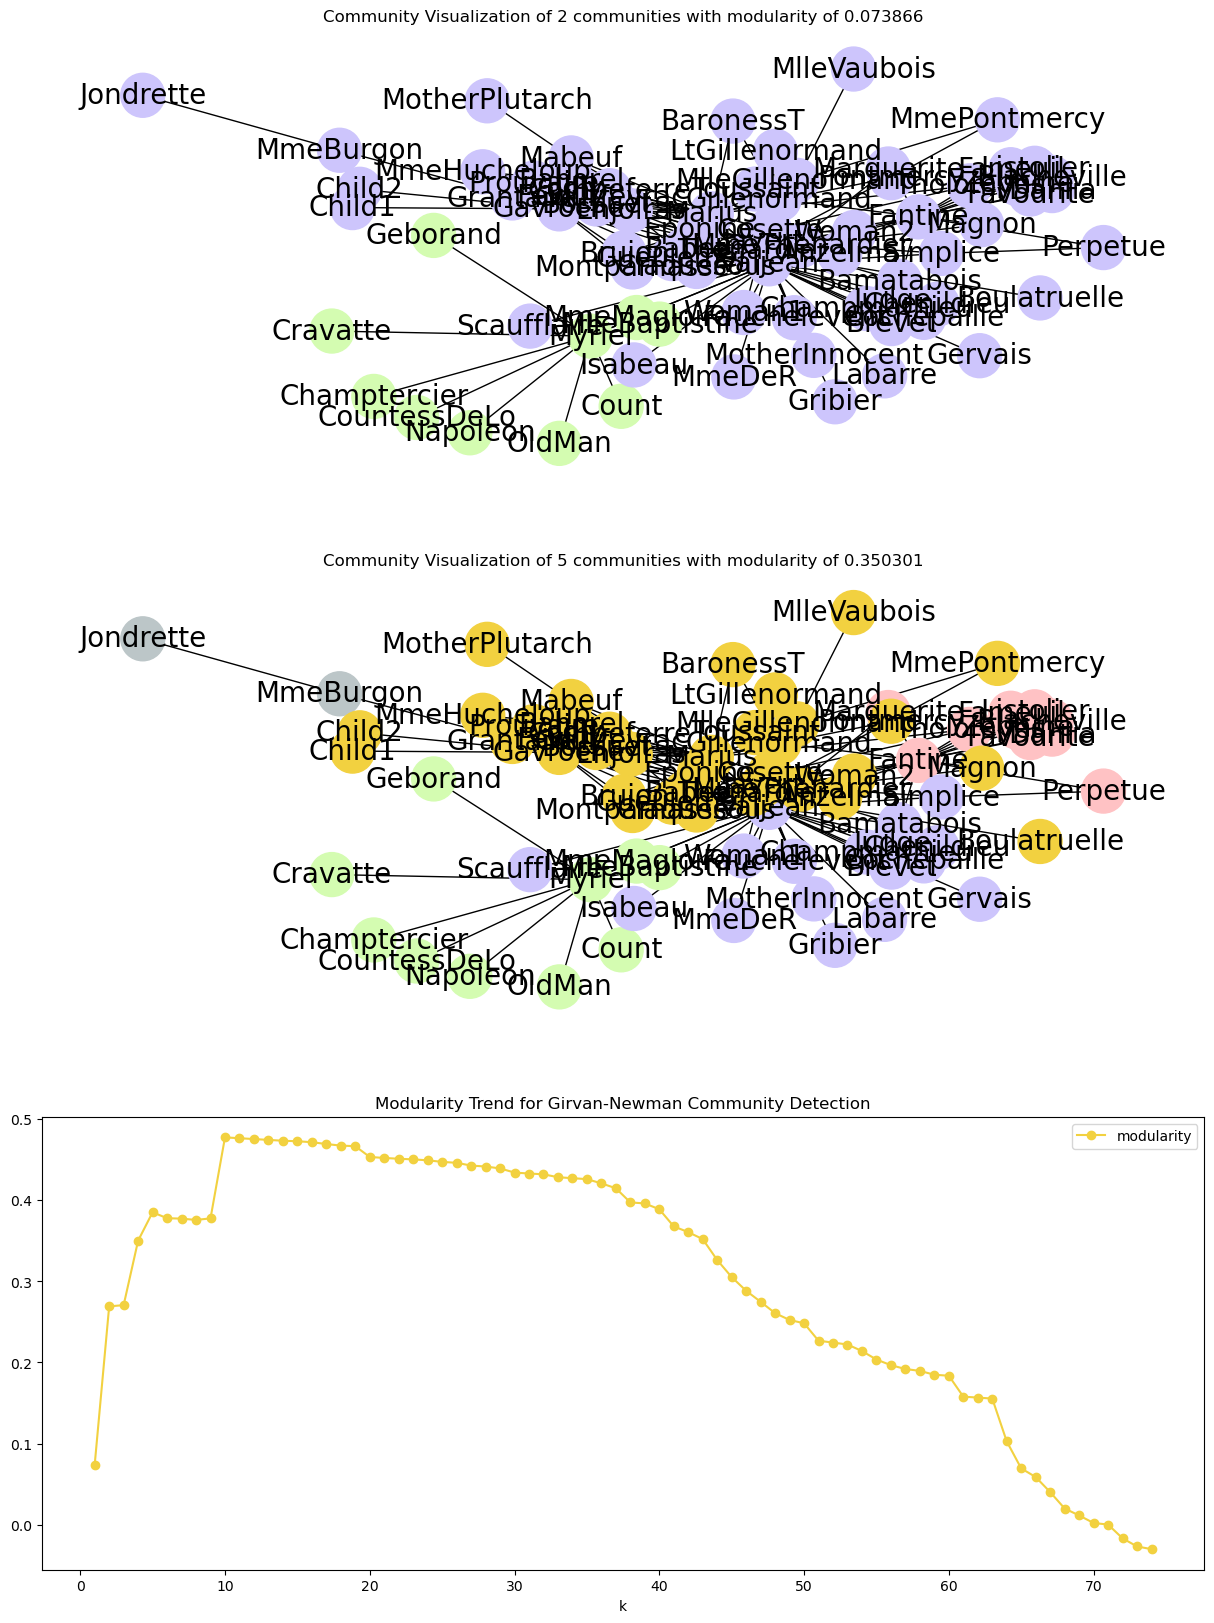

In [32]:
# function to create node colour list
def create_community_node_colors(graph, communities):
    number_of_colors = len(communities)
    colors = ["#D4FCB1", "#CDC5FC", "#FFC2C4", "#F2D140", "#BCC6C8"][:number_of_colors]
    node_colors = []
    for node in graph:
        current_community_index = 0
        for community in communities:
            if node in community:
                node_colors.append(colors[current_community_index])
                break
            current_community_index += 1
    return node_colors


# function to plot graph with node colouring based on communities
def visualize_communities(graph, communities, i):
    node_colors = create_community_node_colors(graph, communities)
    modularity = round(nx.community.modularity(graph, communities), 6)
    title = f"Community Visualization of {len(communities)} communities with modularity of {modularity}"
    pos = nx.spring_layout(graph, k=0.3, iterations=50, seed=2)
    plt.subplot(3, 1, i)
    plt.title(title)
    nx.draw(
        graph,
        pos=pos,
        node_size=1000,
        node_color=node_colors,
        with_labels=True,
        font_size=20,
        font_color="black",
    )


fig, ax = plt.subplots(3, figsize=(15, 20))

# Plot graph with colouring based on communities
visualize_communities(G, communities[0], 1)
visualize_communities(G, communities[3], 2)
modularity_df.plot.line(
    x="k",
    y="modularity",
    ax=ax[2],
    color="#F2D140",
    title="Modularity Trend for Girvan-Newman Community Detection",
    marker='o',  # Thêm dấu chấm tại mỗi điểm trên đường
)

In [ ]:
class CommunityAnalyzer:
    def __init__(self, G):
        self.G = G
        self.communities = list(nx.community.girvan_newman(G))

    def modularity_ratio(self, G, community):
        """Calculate modularity ratio for a community"""
        community = list(community)
        edges_between_community = 0
        for node in community:
            neighbors = set(G.neighbors(node))
            edges_between_community += sum(1 for n in neighbors if n in community)
        edges_between_community //= 2
        expected_edges = sum(G.degree(node) for node in community)**2 / (2 * G.size())
        return edges_between_community / expected_edges if expected_edges != 0 else 0

    def volume(self, G, community):
        """Calculate volume of a community"""
        return sum(G.degree(node) for node in list(community))

    def edges_cut(self, G, community):
        """Calculate number of edges cut for a community"""
        community = list(community)
        return sum(1 for node in community
                  for neighbor in G.neighbors(node)
                  if neighbor not in community)

    def analyze_communities(self):
        """Analyze communities and calculate metrics"""
        metrics_data = []
        for k in range(len(self.communities)//2):
            for community in self.communities[k]:
                metrics_data.append({
                    'k': k + 1,
                    'modularity': nx.community.modularity(self.G, self.communities[k]),
                    'modularity_ratio': self.modularity_ratio(self.G, community),
                    'volume': self.volume(self.G, community),
                    'edges_cut': self.edges_cut(self.G, community)
                })
        return pd.DataFrame(metrics_data)

    def plot_metrics(self, metrics_df):
        print(metrics_df)
        """Create visualizations for metrics and communities"""
        # First figure: Community visualizations and modularity
        fig1, axes1 = plt.subplots(3, 1, figsize=(15, 20))
        fig1.suptitle('Community Structure Analysis', fontsize=16)

        # Plot communities
        for idx, k in enumerate([0, 3]):
            communities = self.communities[k]
            modularity = round(nx.community.modularity(self.G, communities), 6)
            pos = nx.spring_layout(self.G, k=0.3, iterations=50, seed=2)

            axes1[idx].set_title(f"{len(communities)} Communities (Modularity: {modularity})")
            colors = ["#D4FCB1", "#CDC5FC", "#FFC2C4", "#F2D140", "#BCC6C8"]
            node_colors = [colors[list(map(lambda c: node in c, communities)).index(True) % len(colors)]
                         for node in self.G.nodes()]

            nx.draw(self.G, pos=pos, node_color=node_colors, node_size=1000,
                   with_labels=True, font_size=10, font_color="black", ax=axes1[idx])

        # Plot modularity trend
        metrics_df.groupby('k')['modularity'].first().plot(
            ax=axes1[2], color="#F2D140", marker='o',
            title="Modularity Trend")
        axes1[2].set_xlabel("Number of Communities (k)")
        axes1[2].set_ylabel("Modularity")
        axes1[2].grid(True, alpha=0.3)

        # Second figure: Other metrics
        fig2, axes2 = plt.subplots(3, 1, figsize=(15, 20))
        fig2.suptitle('Community Metrics Analysis', fontsize=16)

        metrics = {
            'modularity_ratio': 'Modularity Ratio',
            'volume': 'Volume',
            'edges_cut': 'Edges Cut'
        }

        for idx, (metric, title) in enumerate(metrics.items()):
            metrics_df.groupby('k')[metric].mean().plot(
                ax=axes2[idx], color="#F2D140", marker='o',
                title=f"{title} Trend")
            axes2[idx].set_xlabel("Number of Communities (k)")
            axes2[idx].set_ylabel(title)
            axes2[idx].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        return fig1, fig2

def main():
    import urllib.request
    import io
    def download_and_read_data():
        url = "https://snap.stanford.edu/data/facebook_combined.txt.gz"
        response = urllib.request.urlopen(url)
        data = response.read()
        df = pd.read_csv(io.BytesIO(data),
                        compression='gzip',
                        sep=' ',
                        names=['source', 'target'])
        return df
    df = download_and_read_data()
    G = nx.from_pandas_edgelist(df, "source", "target")
    print(f"Network Info: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

    # Initialize analyzer and calculate metrics
    analyzer = CommunityAnalyzer(G)
    metrics_df = analyzer.analyze_communities()

    # Display metrics
    print("\nCommunity Detection Metrics Summary:")
    summary = metrics_df.groupby('k').agg({
        'modularity': 'first',
        'modularity_ratio': 'mean',
        'volume': 'mean',
        'edges_cut': 'mean'
    }).round(3)
    print(summary)

    # Create visualizations
    analyzer.plot_metrics(metrics_df)

if __name__ == "__main__":
    main()

Network Info: 4039 nodes, 88234 edges
